In [ ]:
import torch 
from torchvision import datasets,transforms as T,models
from torch import optim,nn
import matplotlib.pyplot as plt 
import torch.nn.functional as F 
from torch.utils.data import DataLoader
from collections import OrderedDict
import numpy as np

In [ ]:
train_dir = '/content/drive/My Drive/data/train'
valid_dir = '/content/drive/My Drive/data/valid'
test_dir = '/content/drive/My Drive/data/test'

In [ ]:
train_transform = T.Compose([
    T.Resize((256,256)),
    T.CenterCrop(224),
    T.RandomRotation(0,359),
    T.RandomHorizontalFlip(p = 0.5),
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])


valid_transform = T.Compose([
    T.Resize((256,256)),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

test_transfrom = valid_transform

In [ ]:
trainset = datasets.ImageFolder(train_dir,transform = train_transform)
validset = datasets.ImageFolder(valid_dir,transform = valid_transform)
testset = datasets.ImageFolder(test_dir,transform = test_transfrom)

In [ ]:
trainloader = DataLoader(trainset, batch_size = 64,shuffle = True)
validloader = DataLoader(validset, batch_size = 64,shuffle = True)
testloader = DataLoader(testset, batch_size = 64,shuffle = True)

In [ ]:
#Total no. of examples in Training Set
#Total no. of examples Validation set
#Total no. of examples test set

print(len(trainset))
print(len(validset))
print(len(testset))

2000
150
600


In [ ]:
#Total no. of Batch for TrainSet
#Total no. of Batch for ValidSet
#Total no. of Batch for TestSet

print(len(trainloader))
print(len(validloader))
print(len(testloader))

32
3
10


In [ ]:
def imshow(image):
    image = image.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    plt.imshow(image) 

classes = ['melanoma','nevus','seborrheic_keratosis']

In [ ]:
dataiter = iter(trainloader)
images,labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 3, 224, 224])
torch.Size([64])


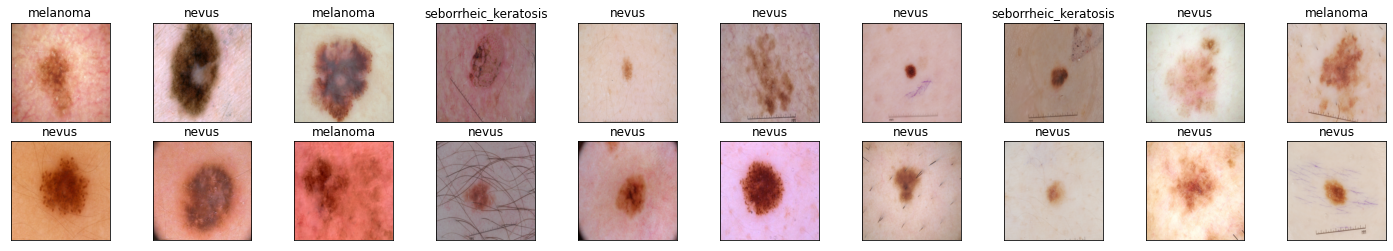

In [ ]:
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [ ]:
model = models.densenet161(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [ ]:
for param in model.parameters():
    param.requires_grad = False




classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(2208, 1024)),
                                         ('relu', nn.ReLU()),
                                         ('dropout',nn.Dropout(0.5)),
                                         ('fc2', nn.Linear(1024, 512)),
                                         ('relu', nn.ReLU()),
                                         ('drop', nn.Dropout(0.5)),
                                         ('fc3', nn.Linear(512, 3)), 
                                         ('output', nn.LogSoftmax(dim=1))]))

model.classifier = classifier
model.cuda()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [ ]:
epochs = 20
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(),lr = 0.001)

train_loss_data = []
val_loss_data = []

valid_loss_min = np.Inf

for i in range(epochs):

    train_loss = 0
    val_loss = 0

    model.train()
  
    for images, labels in trainloader:

        images = images.cuda()
        labels = labels.cuda()
        optimizer.zero_grad()
        logps = model(images)
        loss = criterion(logps,labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()*images.size(0)

    model.eval()

    for images,labels in validloader:


        images = images.cuda() 
        labels = labels.cuda()
        logps = model(images)
        loss = criterion(logps,labels)
        val_loss += loss.item()*images.size(0)

    train_loss = train_loss/len(trainloader.dataset)
    val_loss = val_loss/len(validloader.dataset)

    train_loss_data.append(train_loss)
    val_loss_data.append(val_loss)

    print("Epoch : {} training Loss : {:.6f} Validation Loss : {:.6f} ".format(i+1,train_loss,val_loss))


    if val_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).   Saving model ...'.format(valid_loss_min,val_loss))
        torch.save(model.state_dict(), 'SkinCancerModel.pt')
        valid_loss_min = val_loss

Epoch : 1 training Loss : 0.839751 Validation Loss : 0.864802 
Validation loss decreased (inf --> 0.864802).   Saving model ...
Epoch : 2 training Loss : 0.678961 Validation Loss : 0.871557 
Epoch : 3 training Loss : 0.646627 Validation Loss : 0.762569 
Validation loss decreased (0.864802 --> 0.762569).   Saving model ...
Epoch : 4 training Loss : 0.575603 Validation Loss : 0.676603 
Validation loss decreased (0.762569 --> 0.676603).   Saving model ...
Epoch : 5 training Loss : 0.583534 Validation Loss : 0.686873 
Epoch : 6 training Loss : 0.576475 Validation Loss : 0.754512 
Epoch : 7 training Loss : 0.514078 Validation Loss : 0.676568 
Validation loss decreased (0.676603 --> 0.676568).   Saving model ...
Epoch : 8 training Loss : 0.538269 Validation Loss : 0.742564 
Epoch : 9 training Loss : 0.525966 Validation Loss : 0.783434 
Epoch : 10 training Loss : 0.531008 Validation Loss : 0.685466 
Epoch : 11 training Loss : 0.497699 Validation Loss : 0.770542 
Epoch : 12 training Loss : 0.4

In [ ]:
model.load_state_dict(torch.load('SkinCancerModel.pt'))

<All keys matched successfully>